In [1]:
# requires OpenCV (cv2) and pptk to process & render point clouds

%matplotlib notebook

import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt
# from matplotlib import use
# use("Qt5Agg")
from mpl_toolkits.mplot3d import Axes3D # <--- This is important for 3d plotting 
import pandas as pd
import cv2
import pptk
# from pyntcloud import PyntCloud
# import pyvista as pv
# import pyntcloud


<IPython.core.display.Javascript object>


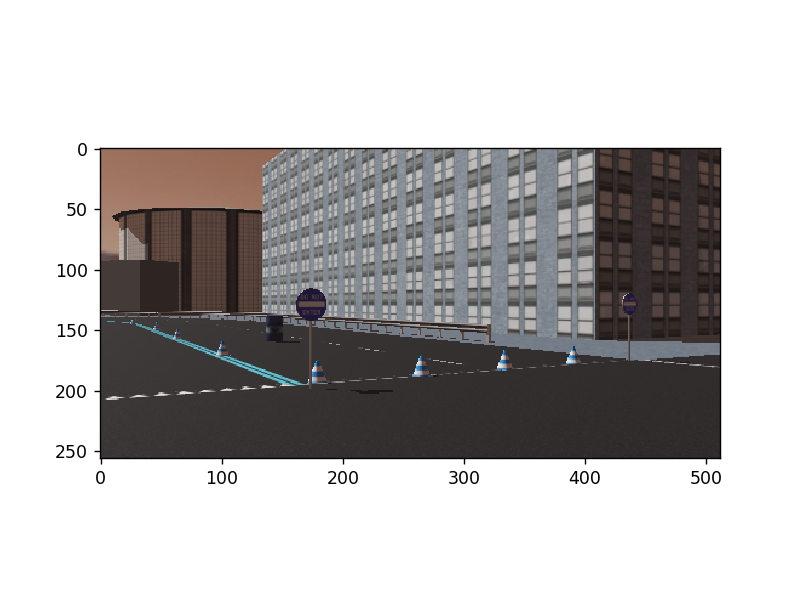

In [2]:
imgL = cv2.imread('left.jpg',0)
imgL_color = cv2.imread('left.jpg',cv2.IMREAD_UNCHANGED)
imgR = cv2.imread('right.jpg',0)
disp_webots = cv2.imread('disp.jpg',0)

# stereo = cv2.StereoSGBM_create(numDisparities=256, blockSize=11)
# stereo = cv2.StereoSGBM_create(numDisparities=16*4, blockSize=(1+2*7))
stereo = cv2.StereoBM_create(numDisparities=16*13, blockSize=(1+2*5))
# stereo.setPreFilterType(1)
disparity = stereo.compute(imgL,imgR)

plt.imshow(imgL_color); plt.show()

In [3]:
b = 0.8
# f = 439.317053211
f = 1874.4194270335508
height = imgL.shape[0]
width = imgL.shape[1]
# zs = b * f * np.reciprocal(np.ma.masked_less_equal(disparity, 0).astype(np.float32))
disparity = disparity.astype(np.float32)
disparity[disparity<1] = np.nan
zc_s = b * f * np.reciprocal(disparity)    * 10         # TODO: magic factor of 10 seems to fix scaling

xc_s = np.multiply(zc_s, np.matlib.repmat((np.linspace(0.0,width-1,width) - 0.5*width) / f, height, 1))
yc_s = np.multiply(zc_s, np.matlib.repmat((np.linspace(0.0,height-1,height) - 0.5*height).reshape(height,1) / f, 1, width))

# convert camera frame from optical-z to optical-x
# df = pd.DataFrame({'x': xs.ravel(), 'y': ys.ravel(), 'z': zs.ravel()})
df = pd.DataFrame({'x': zc_s.ravel(), 'y': -xc_s.ravel(), 'z': -yc_s.ravel()})
df[['blue', 'green', 'red']] = pd.DataFrame(imgL_color.reshape(-1,3), index=df.index)
df.dropna(inplace=True)
# min(zc_s[~np.isnan(zc_s)])

In [4]:
# using pyntcloud
# points = pyntcloud.PyntCloud(df)
# points.plot(point_size=0.1, opacity=0.6)

# using pyvista
# pv_cloud = pv.PolyData(xyz)
# pv_cloud.plot()

filtered = df.to_numpy()
xyz = filtered[:,[0,1,2]]
rgb = filtered[:,[5,4,3]]

# using pptk
# https://heremaps.github.io/pptk/tutorials/viewer/tanks_and_temples.html
v = pptk.viewer(xyz, point_size=10.0)
v.attributes(rgb / 255.0)
v.set(bg_color_bottom=[1.,1.,1.,1.], lookat=[0.,0.,0.], phi=3.14, theta = 0.3, r=2.0)